In [1]:
import os

current_dir = os.getcwd()
print('CWD: ', current_dir.split('/')[-1])
print('{} contains: {}'.format(current_dir.split('/')[-1], os.listdir()))
train_images = os.path.join(current_dir, 'train')
print('[Train] Images path:', train_images)
test_images = os.path.join(current_dir, 'test')
print('[Test]  Images path:', test_images)

CWD:  aerial-cactus-identification
aerial-cactus-identification contains: ['sample_submission.csv', '.ipynb_checkpoints', 'Aerial_cactus_det.ipynb', 'train.csv', 'train', 'test']
[Train] Images path: /home/keval/kaggle data/aerial-cactus-identification/train
[Test]  Images path: /home/keval/kaggle data/aerial-cactus-identification/test


## Imports

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import cv2

sns.set_style('darkgrid')

## Read Data

### Training Data

In [3]:
train = pd.read_csv('train.csv')
print(train.shape)
train.head(5)

(17500, 2)


,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17500 entries, 0 to 17499
Data columns (total 2 columns):
id            17500 non-null object
has_cactus    17500 non-null int64
dtypes: int64(1), object(1)
memory usage: 273.6+ KB


### Training Data Visulaization

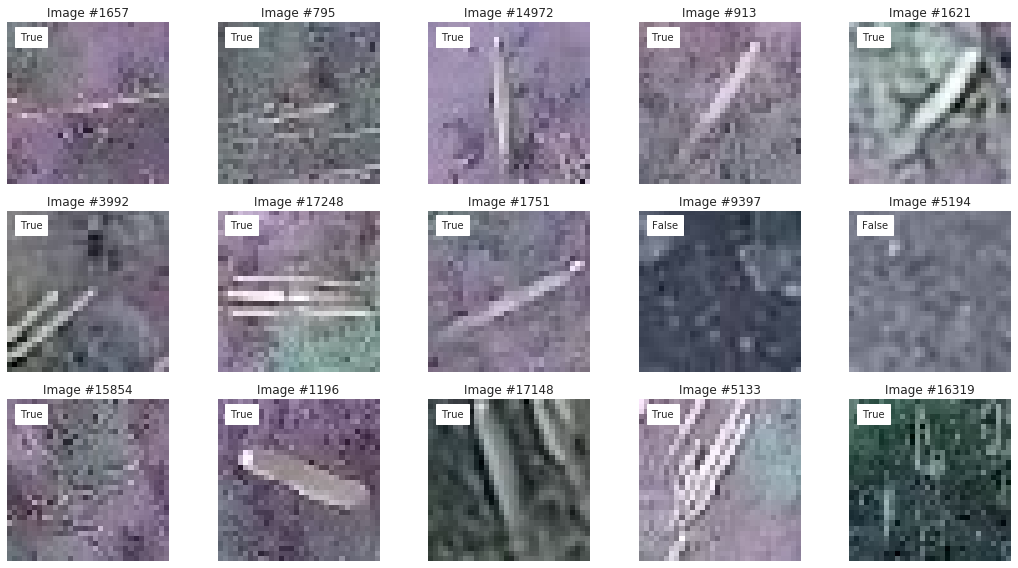

In [5]:
rand_ord = np.random.permutation(train.shape[0])

fig = plt.figure(figsize=(15, 8))

for i in range(15):
    img = cv2.imread(os.path.join(train_images, train['id'][rand_ord[i]]))
    cactus = 'True' if train['has_cactus'][rand_ord[i]] == 1 else 'False'
    ax = plt.subplot(3, 5, i+1)
    ax.set_title('Image #' + str(rand_ord[i]))
    ax.imshow(img)
    ax.text(2, 3, cactus, bbox={'facecolor': 'white', 'pad': 5})
    ax.grid(False)
    ax.axis('off')

plt.tight_layout()
plt.show()

### Test Data Visualization

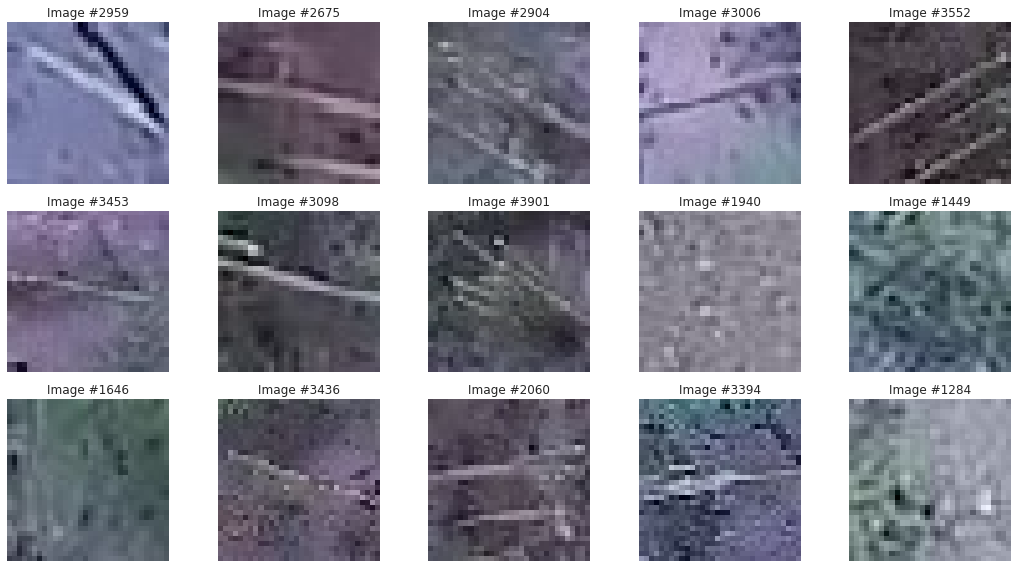

In [6]:
test_img_list = os.listdir(test_images)
test_rand_ord = np.random.permutation(len(test_img_list))

fig = plt.figure(figsize=(15, 8))

for i in range(15):
    img = cv2.imread(os.path.join(test_images, test_img_list[test_rand_ord[i]]))
    ax = plt.subplot(3, 5, i+1)
    ax.set_title('Image #' + str(test_rand_ord[i]))
    ax.imshow(img)
    ax.grid(False)
    ax.axis('off')

plt.tight_layout()
plt.show()

## PyTorch

In [7]:
import torch
from torch import nn, optim
from torch.nn import functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset
from torch.autograd import Variable
from torch.optim import lr_scheduler
from torchvision import models, transforms
from torchvision.utils import make_grid
from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Transformation

In [28]:
image_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(224),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                        [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                        [0.229, 0.224, 0.225])
])

### Dataset

In [9]:
class ImageDataset(Dataset):
    
    def __init__(self, data, folder, transform=None):
        super().__init__()
        self.df = data
        self.dir = folder
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        
        # get the name and the has_cactus value from the dataframe
        img_name, img_has_cactus = self.df.iloc[index]
        
        # Read image from the dir
        img = cv2.imread(os.path.join(self.dir, img_name))
        
        # Apply Transformation if nor None
        if self.transform:
            img = self.transform(img)
        
        return img, img_has_cactus

### DataLoader

In [10]:
# Split the training data into Train and Validation
train, valid = train_test_split(train, train_size=0.8)

# Create Dataset for train & Validation data
train_dataset = ImageDataset(data=train, folder=train_images, transform=image_transform)
val_dataset = ImageDataset(data=valid, folder=train_images, transform=image_transform)

batch_sz = 8
# train dataloader
train_loader = DataLoader(train_dataset, batch_size=batch_sz, shuffle=True, num_workers=4)

# Validation dataloader
val_loader = DataLoader(val_dataset, batch_size=batch_sz, shuffle=True, num_workers=4)

### Batch Visulaization

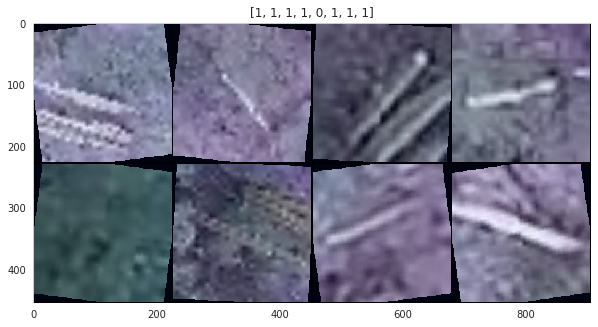

In [12]:
def imshow(img, title=''):
    
    plt.figure(figsize=(10, 10))
    plt.title(title)
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    plt.grid(False)
    plt.show()

for i, data in enumerate(train_loader):
    x, y = data
    imshow(make_grid(x, 4, normalize=True), title=[x.item() for x in y])
    break

### Model

In [19]:
resnet_50 = models.resnet50(pretrained=True)
resnet_50

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [20]:
# Freeze model parameters
for param in resnet_50.parameters():
    param.requires_grad = False
    
# Change the final layer of ResNet50 Model
fc_inputs = resnet_50.fc.in_features
 
resnet_50.fc = nn.Sequential(
    nn.Linear(fc_inputs, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, 128),
    nn.Linear(128, 10),
    nn.Linear(10, 2)
)

resnet_50 = resnet_50.to(device)
optimizer = optim.Adam(resnet_50.parameters())
criterion = nn.CrossEntropyLoss()

In [21]:
summary(resnet_50, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

### Train & Validation

In [30]:
%%time
import time
import copy

epochs = 20
train_losses, val_losses = [], []
train_acc, val_acc = [], []
start_time = time.time()
counter = 0
best_val_loss = float('Inf')

for e in range(epochs):
    epoch_start_time = time.time()
    running_loss = 0
    
    # TRAINING PART
    accuracy = 0
    resnet_50.train()
    for images, label in train_loader:
        # load data to GPU
        images = images.to(device)
        label = label.to(device)
        
        optimizer.zero_grad()
        output = resnet_50(images)
        
        # Compute the accuracy
        ret, predictions = torch.max(output.data, 1)
        correct_counts = predictions.eq(label.data.view_as(predictions))
         
        # Convert correct_counts to float and then compute the mean
        accuracy += torch.mean(correct_counts.type(torch.FloatTensor))
        
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        del images, label, output
    
    # record training loss and error, then evaluate using validation data
    train_losses.append(running_loss/len(train_loader))
    train_acc.append(accuracy/len(train_loader))
    
    # VALIDATION PART
    val_loss = 0
    accuracy = 0
    resnet_50.eval()
    with torch.no_grad():
        for images, label in val_loader:
            images = images.to(device)
            label = label.to(device)
            output = resnet_50(images)
            
            # Compute the accuracy
            ret, predictions = torch.max(output.data, 1)
            correct_counts = predictions.eq(label.data.view_as(predictions))

            # Convert correct_counts to float and then compute the mean
            accuracy += torch.mean(correct_counts.type(torch.FloatTensor))
        
            val_loss += criterion(output, label)
            
            del images, label, output

    val_losses.append(val_loss/len(val_loader))
    val_acc.append(accuracy/len(val_loader))

    print("Epoch: {}/{}.. ".format(e+1, epochs),
          "Time: {:.2f}s..".format(time.time()-epoch_start_time),
          "Training Loss: {:.3f}.. ".format(train_losses[-1]),
          "Training Accu: {:.3f}.. ".format(train_acc[-1]),
          "Val Loss: {:.3f}.. ".format(val_losses[-1]),
          "Val Accu: {:.3f}".format(val_acc[-1]))
        
best_model_wts = copy.deepcopy(resnet_50.state_dict())
resnet_50.load_state_dict(best_model_wts)

Epoch: 1/20..  Time: 50.35s.. Training Loss: 0.119..  Training Accu: 0.955..  Val Loss: 0.068..  Val Accu: 0.977
Epoch: 2/20..  Time: 50.15s.. Training Loss: 0.113..  Training Accu: 0.955..  Val Loss: 0.064..  Val Accu: 0.984
Epoch: 3/20..  Time: 51.14s.. Training Loss: 0.107..  Training Accu: 0.960..  Val Loss: 0.041..  Val Accu: 0.985
Epoch: 4/20..  Time: 51.23s.. Training Loss: 0.105..  Training Accu: 0.959..  Val Loss: 0.046..  Val Accu: 0.986
Epoch: 5/20..  Time: 51.70s.. Training Loss: 0.115..  Training Accu: 0.956..  Val Loss: 0.051..  Val Accu: 0.981
Epoch: 6/20..  Time: 50.86s.. Training Loss: 0.109..  Training Accu: 0.959..  Val Loss: 0.058..  Val Accu: 0.976
Epoch: 7/20..  Time: 51.21s.. Training Loss: 0.109..  Training Accu: 0.959..  Val Loss: 0.061..  Val Accu: 0.977
Epoch: 8/20..  Time: 50.50s.. Training Loss: 0.110..  Training Accu: 0.957..  Val Loss: 0.052..  Val Accu: 0.983
Epoch: 9/20..  Time: 50.20s.. Training Loss: 0.104..  Training Accu: 0.962..  Val Loss: 0.047.. 

<All keys matched successfully>

### Free up cache and save model

In [31]:
torch.cuda.empty_cache()

torch.save(resnet_50.state_dict(), 'aerial_cactus_det.pth')

### Plot Accuracy and Loss Graph

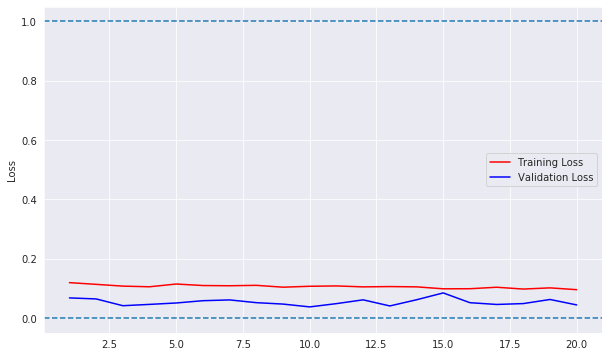

In [33]:
# Training Loss & Validation Loss
plt.figure(figsize=(10,6))

plt.ylabel('Loss')
plt.plot(range(1, epochs + 1), train_losses[:epochs+1], 'r', label='Training Loss')
plt.plot(range(1, epochs + 1), val_losses[:epochs+1], 'b', label='Validation Loss')
plt.axhline(y=0, linestyle='--')
plt.axhline(y=1, linestyle='--')
plt.legend()

plt.show()

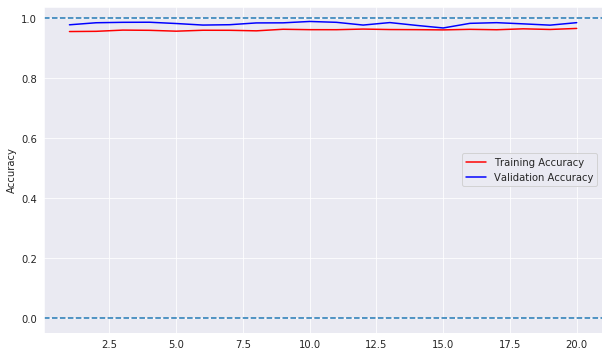

In [34]:
# Training Accuracy & Validation Accuracy
plt.figure(figsize=(10,6))

plt.ylabel('Accuracy')
plt.plot(range(1, epochs + 1), train_acc[:epochs+1], 'r', label='Training Accuracy')
plt.plot(range(1, epochs + 1), val_acc[:epochs+1], 'b', label='Validation Accuracy')
ax.grid(linestyle='-')
plt.axhline(y=0, linestyle='--')
plt.axhline(y=1, linestyle='--')
plt.legend()

plt.show()

### Prediction on Test Data

In [41]:
# Prepare Test Data for prediction

test = pd.read_csv('sample_submission.csv')

test_dataset = ImageDataset(data=test, folder=test_images, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=batch_sz, shuffle=False, num_workers=4)

In [46]:
%%time

# Prediction
predict = []
resnet_50.eval()

for i, (data, _) in enumerate(test_loader):
    data = data.cuda()
    
    output = resnet_50(data)    

    _, predicted = torch.max(output.data, 1)
    for i in predicted.data.cpu().numpy():
        predict.append(int(i))

test['has_cactus'] = predict

CPU times: user 8.12 s, sys: 2.08 s, total: 10.2 s
Wall time: 10.4 s


In [47]:
test.head()

,id,has_cactus
0,000940378805c44108d287872b2f04ce.jpg,1
1,0017242f54ececa4512b4d7937d1e21e.jpg,1
2,001ee6d8564003107853118ab87df407.jpg,0
3,002e175c3c1e060769475f52182583d0.jpg,0
4,0036e44a7e8f7218e9bc7bf8137e4943.jpg,1


### Test Visulaization

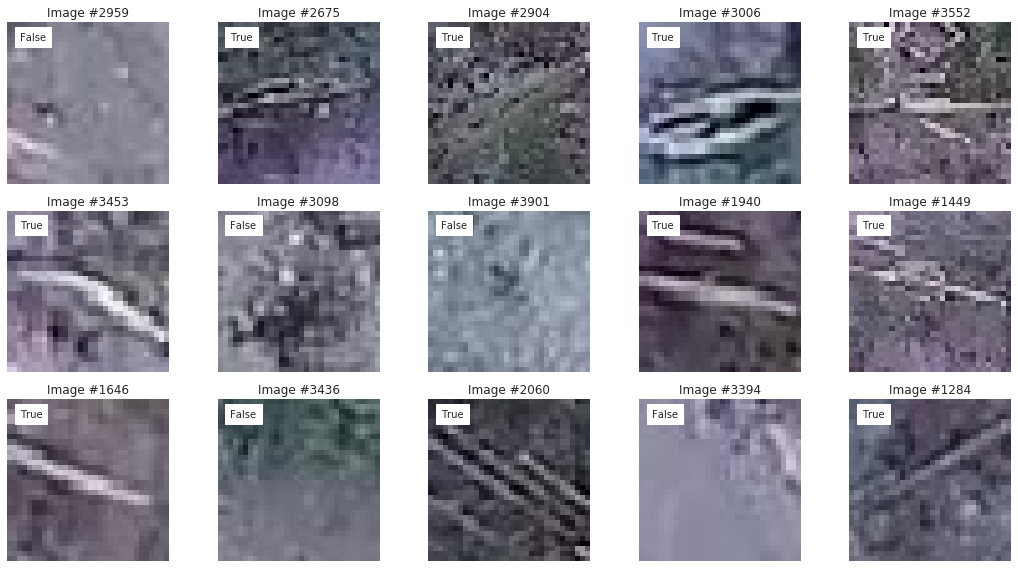

In [44]:
fig = plt.figure(figsize=(15, 8))

for i in range(15):
    img = cv2.imread(os.path.join(test_images, test.id[test_rand_ord[i]]))
    cactus = 'True' if test['has_cactus'][test_rand_ord[i]] == 1 else 'False'
    ax = plt.subplot(3, 5, i+1)
    ax.set_title('Image #' + str(test_rand_ord[i]))
    ax.imshow(img)
    ax.text(2, 3, cactus, bbox={'facecolor': 'white', 'pad': 5})
    ax.grid(False)
    ax.axis('off')

plt.tight_layout()
plt.show()

## CSV Generation

In [45]:
test.to_csv('submission.csv', index=False)